In [21]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Text processing and regex
import re
import string

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [29]:
import pandas as pd

# path
path = r"C:\Users\mcsmu\Desktop\Machine Learning Final Implementation\spam.csv"

# Load the CSV file
df = pd.read_csv(path, encoding='latin-1')

# Keep only relevant columns and rename
df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'message'})

# Drop any missing rows (very few or none)
df.dropna(inplace=True)

# Confirm result
print("Cleaned dataset shape:", df.shape)
print("\nSample rows:\n", df.sample(5))


Cleaned dataset shape: (5572, 2)

Sample rows:
      label                                            message
2520   ham  Misplaced your number and was sending texts to...
2945   ham                      make that 3! 4 fucks sake?! x
1822   ham      If you're thinking of lifting me one then no.
2828  spam  Send a logo 2 ur lover - 2 names joined by a h...
3874   ham  Okie but i scared u say i fat... Then u dun wa...


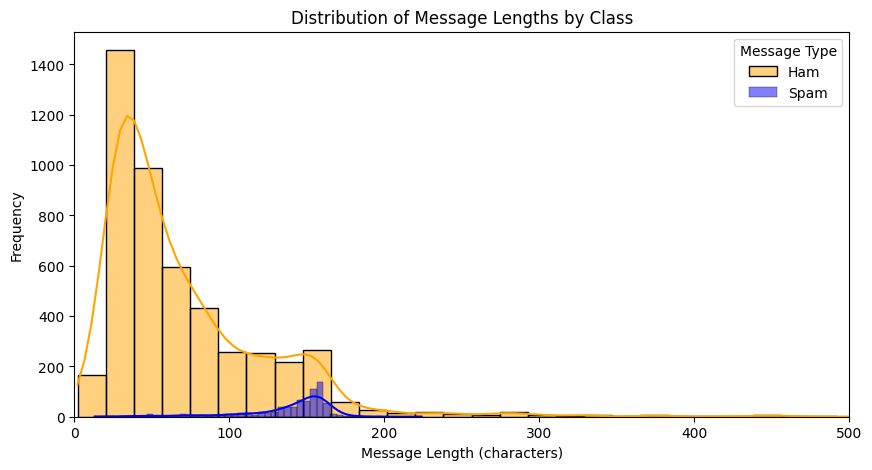

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Encode labels: ham = 0, spam = 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Filter valid entries
df = df[df['label'].isin([0, 1])]
df = df[df['message'].str.strip() != '']

#  message length
df['length'] = df['message'].apply(len)

# Map label values for readable plotting
df['label_str'] = df['label'].map({0: 'Ham', 1: 'Spam'})

# Plot histogram 
plt.figure(figsize=(10, 5))
sns.histplot(df[df['label_str'] == 'Ham']['length'], color='orange', label='Ham', bins=50, kde=True)
sns.histplot(df[df['label_str'] == 'Spam']['length'], color='blue', label='Spam', bins=50, kde=True)

plt.title('Distribution of Message Lengths by Class')
plt.xlabel('Message Length (characters)')
plt.ylabel('Frequency')
plt.xlim(0, 500)
plt.legend(loc='upper right', title='Message Type')
plt.show()


In [32]:
# Define stopwords 
stop_words = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 
    'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 
    'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 
    'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 
    'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 
    'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 
    'will', 'just', 'don', 'should', 'now'
])

# clean and remove stopwords
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    words = text.split()
    words = [word for word in words if word not in stop_words]  # remove stopwords
    return ' '.join(words)

# Apply the cleaning function
df['message'] = df['message'].apply(clean_text)


In [37]:
from collections import Counter

# Tokenize cleaned messages 
df['tokens'] = df['message'].apply(lambda x: x.split())

#  Create vocabulary from all tokens
def create_vocabulary(all_tokens):
    vocabulary = set()
    for tokens in all_tokens:
        vocabulary.update(tokens)
    return sorted(vocabulary)

vocabulary = create_vocabulary(df['tokens'])
print(f"Vocabulary size: {len(vocabulary)}")

#  Create BoW vectors for each message
def create_bow_vector(tokens, vocabulary):
    word_counts = Counter(tokens)
    return [word_counts.get(word, 0) for word in vocabulary]

# Create BoW vectors
X_bow = [create_bow_vector(tokens, vocabulary) for tokens in df['tokens']]
y = df['label'].values


Vocabulary size: 8496


In [42]:
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split
import numpy as np

# Convert BoW list to sparse matrix
X_bow_matrix = csr_matrix(X_bow)

# Reshape message length and convert to sparse
length_col = df['length'].values.reshape(-1, 1)
length_sparse = csr_matrix(length_col)

# Combine BoW vectors with message length
X_combined = hstack([X_bow_matrix, length_sparse])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)


print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


print("\n📊 Label distribution:")

print("\nTraining set:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    label_name = 'Ham' if label == 0 else 'Spam'
    print(f"{label_name}: {count}")

print("\nTesting set:")
unique, counts = np.unique(y_test, return_counts=True)
for label, count in zip(unique, counts):
    label_name = 'Ham' if label == 0 else 'Spam'
    print(f"{label_name}: {count}")


Training shape: (4457, 8497)
Testing shape: (1115, 8497)

📊 Label distribution:

Training set:
Ham: 3859
Spam: 598

Testing set:
Ham: 966
Spam: 149


✅ Best alpha: 1.0
Cross-validation scores for each alpha: [0.97015849 0.96701595 0.97195221 0.97935886 0.94368246]
Best cross-validation accuracy: 0.9794
✅ Best model and vectorizer saved.


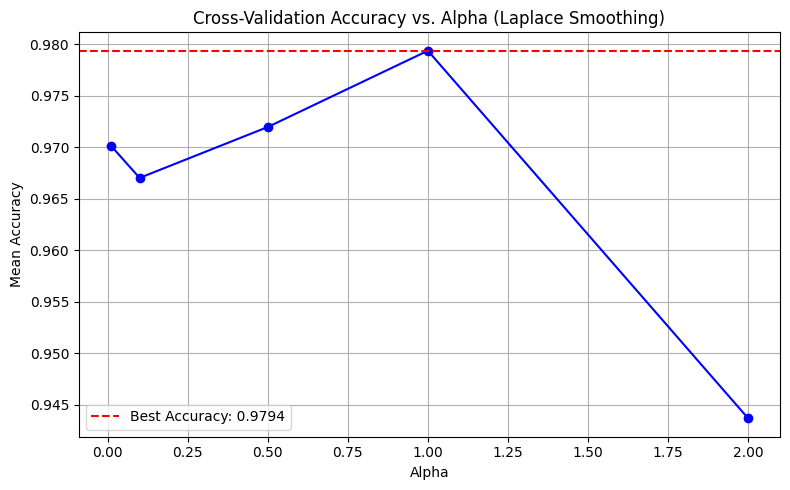

In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
import joblib



# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

#  Define model and parameter grid
model = MultinomialNB()
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]}

#  Use GridSearchCV to find best alpha
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

#  Extract best model
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['alpha']
cv_scores = grid_search.cv_results_['mean_test_score']

print(f"✅ Best alpha: {best_alpha}")
print("Cross-validation scores for each alpha:", cv_scores)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Save the best model and vectorizer
joblib.dump(best_model, 'best_spam_classifier_model.joblib')
joblib.dump(vectorizer, 'vectorizer.joblib')
print("✅ Best model and vectorizer saved.")

#  Plot accuracy vs alpha
plt.figure(figsize=(8, 5))
plt.plot(param_grid['alpha'], cv_scores, marker='o', linestyle='-', color='blue')
plt.axhline(grid_search.best_score_, color='red', linestyle='--', label=f'Best Accuracy: {grid_search.best_score_:.4f}')
plt.title('Cross-Validation Accuracy vs. Alpha (Laplace Smoothing)')
plt.xlabel('Alpha')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



📊 Model Performance on Test Set:

   Metric    Value
 Accuracy 0.977578
Precision 0.936620
   Recall 0.892617
 F1 Score 0.914089


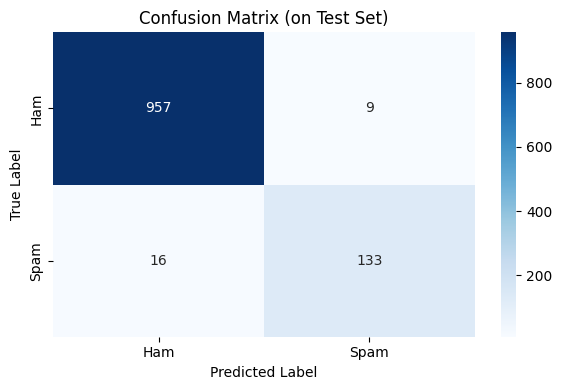

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import numpy as np
import pandas as pd

#  Load the best model and vectorizer
model = joblib.load('best_spam_classifier_model.joblib')
vectorizer = joblib.load('vectorizer.joblib')

#  Predict on X_test
y_pred = model.predict(X_test)


accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)


metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value':  [accuracy, precision, recall, f1]
})

print("\n📊 Model Performance on Test Set:\n")
print(metrics_df.to_string(index=False))


cm = confusion_matrix(y_test, y_pred)
labels = ['Ham', 'Spam']

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (on Test Set)')
plt.tight_layout()
plt.show()
